In [1]:
import pandas as pd
import numpy as np
import math
import glob
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import cooler
from src.Graphs import compute_nx_graph_from_regions

In [2]:
coolerpath ={'WT':'/disk2/dh486/cooler_files/WT/manually_downsampled/KR/KR_downsampled_WT_merged_10000.cool',
             'KO':'/disk2/dh486/cooler_files/KO/KR/KR_KO_merged_10000.cool'
            }

In [5]:
from src.Graphs import compute_ptg_graph_from_regions
x = compute_ptg_graph_from_regions(coolerpath['WT'],
                                   {'chr2':np.array([[8651256,10658971]])},
                                   names = {'chr2': ['Ppp2r2c']},
                                   balance = True, 
                                   join = False)

x

[{'edge_index': array([[  0.,   0.,   0., ..., 198., 198., 199.],
         [  0.,   1.,   2., ..., 199., 200., 200.]]),
  'edge_attrs': array([[ 45.51099203,   0.        ,   0.        ],
         [ 71.47081371,   1.        ,   0.        ],
         [ 29.6403106 ,   0.        ,   0.        ],
         ...,
         [ 87.46075588,   1.        ,   0.        ],
         [ 41.5707432 ,   0.        ,   0.        ],
         [113.3756405 ,   1.        ,   0.        ]]),
  'x': array([[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]]),
  'node_info':     chrom     start       end    weight
  0    chr2   8650000   8660000  1.323035
  1    chr2   8660000   8670000  1.059222
  2    chr2   8670000   8680000  0.772526
  3    chr2   8680000   8690000  1.269567
  4    chr2   8690000   8700000  1.212249
  ..  

In [3]:
def draw_circular(graph, ax, cmap = plt.cm.Blues, weightnorm = None):
    pos = nx.circular_layout(graph)
    #nx.draw_networkx_nodes(graph, pos = pos,node_size=30,ax=ax)

    edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())

    if weightnorm is None:
        weightnorm = np.percentile(weights,90)
    normalize = mpl.colors.Normalize(vmin=0, vmax=weightnorm)
    for jdx in np.argsort(weights):
        nx.draw_networkx_edges(graph, 
                           pos, 
                           ax = ax,
                           edgelist=[edges[jdx]], 
                           edge_color = cmap(normalize(weights[jdx])), 
                           connectionstyle='arc3,rad=0.3')

    labels = {item[0]: item[1].split(":")[1].split("-")[0] for item in graph.nodes(data='bin_regions') if int(item[0])%20 == 0}
    poslabels = nx.draw_networkx_labels(graph,{key: 1.1*pos[key] for key in pos},labels = labels,ax= ax)
    
    return weightnorm, pos

def highlight_nodes(graph, nodes,ax, pos, **kwargs):
    nx.draw_networkx_nodes(graph, pos = pos,ax=ax, **kwargs)
    
def compare_gene(gene_reg, gene_name):
    gene_intregs = gene_reg.split(":")[1]
    gene_intregs = [int(item.replace(',', '')) for item in gene_intregs.split("-")]
    c = cooler.Cooler(coolerpath['WT'])
    mynodes = c.bins().fetch(gene_reg).index.values

    regions = {
        gene_reg.split(":")[0]: np.array([[gene_intregs[0]-int(4e5),gene_intregs[1]+int(4e5)]])
    }
    graphs = {cond: compute_nx_graph_from_regions(coolerpath[cond],
                                                  regions,
                                                  join= True,
                                                  force_disjoint = True,
                                                  balance = True) for cond in ['WT','KO']}

    fig, ax = plt.subplots(1,2, figsize = (16,8))
    plt.tight_layout()
    for idx in [0,1]:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
    
    pos = {}
    KO_weightnorm,pos['KO'] = draw_circular(graphs['KO'],
                                        ax[0],
                                        cmap = plt.cm.Reds)
    ax[0].set_title(f"KO contacts\n{graphs['KO'].graph['regions']}\n{gene_name} highlighted",
                size = 15)

    nx.draw_networkx_nodes(graphs['KO'],
                       pos = pos['KO'],
                       ax=ax[0],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    WT_weightnorm, pos['WT'] = draw_circular(graphs['WT'],
                                         ax[1],
                                         weightnorm = KO_weightnorm)
    ax[1].set_title(f"WT contacts\n{graphs['WT'].graph['regions']}\n{gene_name} highlighted",
                size = 15)
    nx.draw_networkx_nodes(graphs['WT'],
                       pos = pos['WT'],
                       ax=ax[1],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    for idx in [0,1]:
        ax[idx].set_xlim([-1.3,1.2])
        ax[idx].set_ylim([-1.2,1.2])
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])

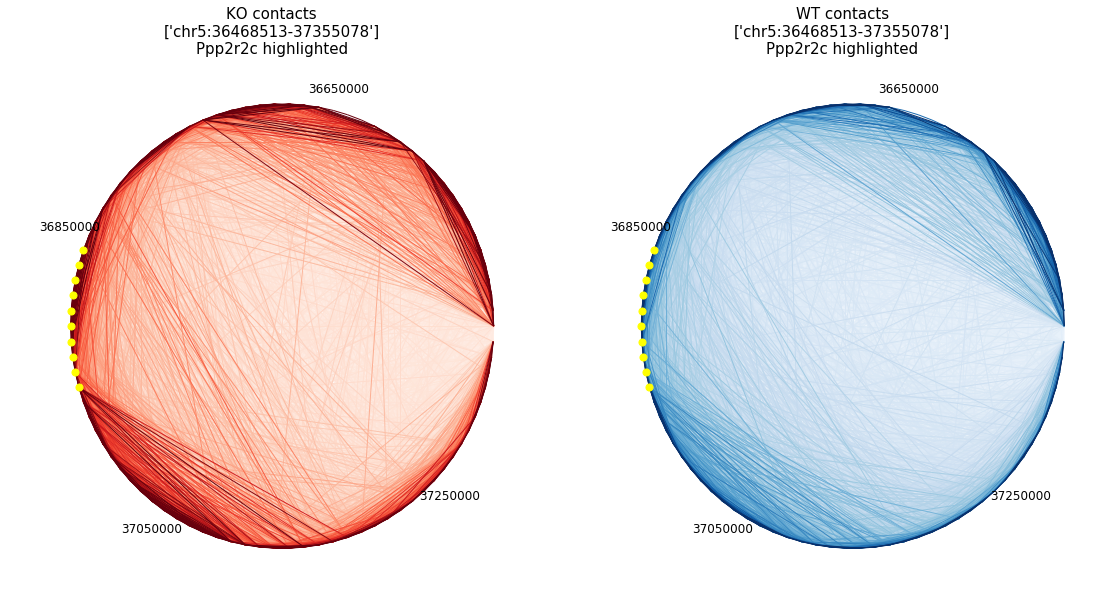

In [4]:
compare_gene(gene_reg = "chr5:36,868,513-36,955,078",gene_name = 'Ppp2r2c')

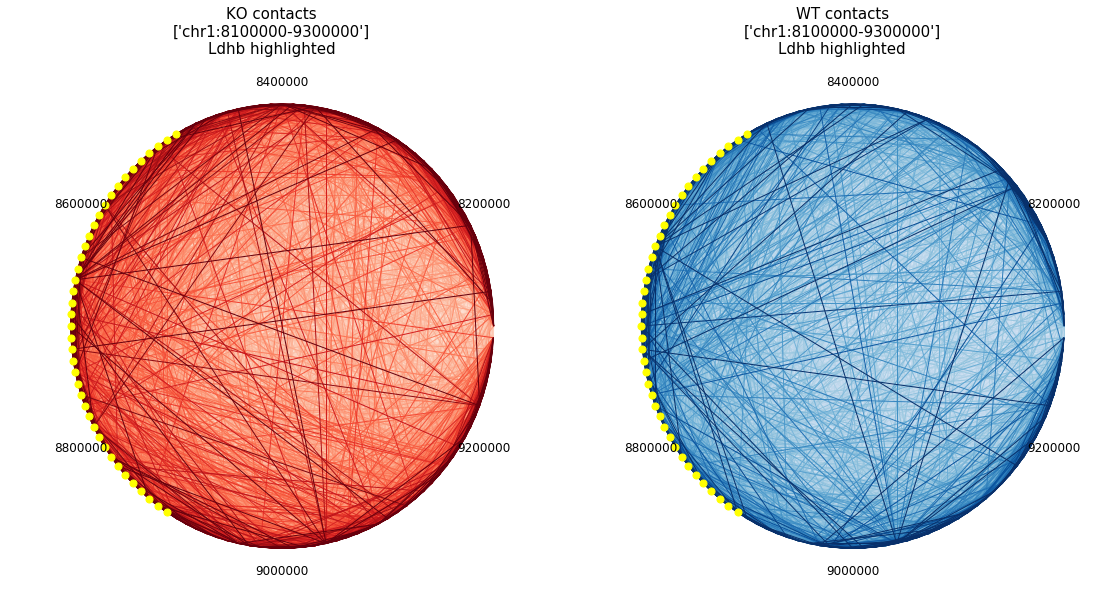

In [5]:
compare_gene(gene_reg = 'chr1:8,500,000-8,900,000',gene_name = 'Ldhb')

In [6]:
graphs = compute_nx_graph_from_regions(coolerpath['WT'],
                                       {'chr1':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr2':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr3':np.array([[8100000,9310000],
                                                         [9340000,10110000]])
                                       },
                                       balance = True, join = True, force_disjoint = True)



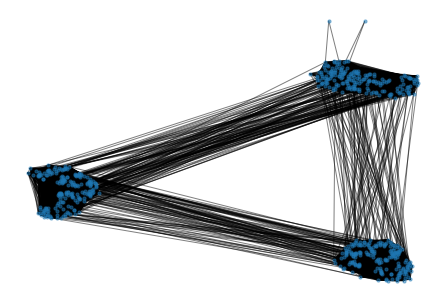

In [7]:
nx.draw(graphs,node_size = 10,alpha = 0.5)

In [8]:
graphs = compute_nx_graph_from_regions(coolerpath['WT'],
                                       {'chr1':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr2':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr3':np.array([[8100000,9310000],
                                                         [9340000,10110000]])
                                       },
                                       balance = True)



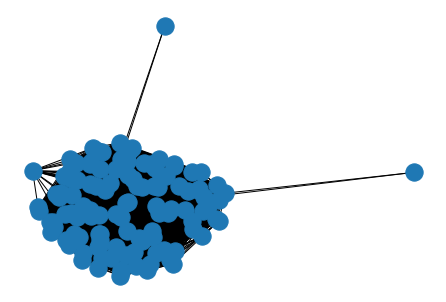

In [9]:
nx.draw(graphs[0])

In [128]:
import glob

tmp = pd.read_csv('/disk1/dh486/Data/rnaseq/kallisto_ncrna_ERCC92_wayne_processed_abundance_norm.txt',
                  sep = "\t"
                 )

In [131]:
tmp

,chromosome,prom_start,prom_end,transcript_start,transcript_end,ens_id,lfc,strand,log10KO_exp,log10WT_exp,name
0,3,108145651,108147137,108107280,108146151,ENSMUSG00000000001,0.052546,-1,1.722002,1.774547,Gnai3
1,X,77853128,77854614,77837901,77853628,ENSMUSG00000000003,-0.002751,-1,0.001375,-0.001375,Pbsn
2,16,18811096,18812978,18780447,18811596,ENSMUSG00000000028,-0.112532,-1,1.700354,1.587822,Cdc45
3,7,142576415,142579134,142575529,142576915,ENSMUSG00000000031,0.528073,-1,0.460089,0.988163,H19
4,X,161161759,161163555,161163055,161258213,ENSMUSG00000000037,-0.474546,1,1.329332,0.854785,Scml2
...,...,...,...,...,...,...,...,...,...,...,...
41464,17,29548808,29550294,29549794,29682012,ENSMUSG00000099329,-0.014677,1,0.013417,-0.001259,Gm28052
41465,7,44537683,44539169,44538106,44538183,ENSMUSG00000099330,0.427555,-1,-0.002683,0.424872,Mir7053
41466,11,46169096,46170582,46170082,46170143,ENSMUSG00000099331,-0.002751,1,0.001375,-0.001375,Mir7239
41467,17,85617076,85618562,85618062,85618265,ENSMUSG00000099332,-0.002751,1,0.001375,-0.001375,Gm27502
